In [1]:
%matplotlib inline
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import torch
import torch.nn.functional as F
import torch._C._te as te

scope = te.KernelScope()

from utils import *

- compute_inline is a little bit awkward, since you need access to intermediate Tensors. I think TVM has something that automatically tries to inline whatever is possible?
- 

In [9]:
def np_matmul_timer(n):
    a, b, c, = get_abc((n, n), torch.tensor)
    return timer_iters(lambda: torch.matmul(a, b,out=c))
sizes = 2**np.arange(5, 11, 1)
exe_times = [bench_workload(np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes **3 / 1e9 / np.array(exe_times)

time:  1.4692079275846481e-05
time:  1.0489951819181442e-05
time:  4.612887278199196e-05
time:  0.0003270297311246395
time:  0.00232864310964942
time:  0.019817268010228872


In [3]:
def matmul(n, m, l):
    A = te_placeholder((n, l), name='A')
    B = te_placeholder((l, m), name='B')
    def f(n, m, l):
        return A.load([n, l]) * B.load([l, m])
    mm = te.Compute('mm', get_dim_args([n,m,l]), f)
    C = te.Reduce('C', get_dim_args([n, m]), te.Sum(), mm, get_dim_args([l]))
    return (A, B, C, mm)

def default(n):
    A, B, C, mm = matmul(n, n, n)
    s = te.LoopNest([C])
    s.compute_inline(s.get_loop_body_for(mm))
    return s, (A, B, C)

def reorder(n):
    s, (A,B,C) = default(n)
    loops = s.get_loops_for(C)
    s.reorder(loops[1], loops[2])
    return s, (A, B, C)

In [4]:
def bench_matmul_tvm(func, sizes):
    def workload(nrepeats):
        time = timeit.timeit(lambda: mod(a,b,c), number=nrepeats)
        return time
    times = []
    for n in sizes:
        n = int(n)
        s, (A, B, C) = func(n)
        s.prepare_for_codegen()
        mod = te_codegen('llvm', s.simplify(), [A, B, C])
        a, b, c = get_abc((n, n), torch.tensor)
        times.append(bench_workload(workload))
    return 2 * sizes**3 / 1e9 / np.array(times)

In [5]:
default_gflops = bench_matmul_tvm(default, sizes)

time:  6.847083568572998e-06
time:  0.0001621250994503498
time:  0.0017380728386342525
time:  0.015968734864145517
time:  0.19476458430290222
time:  1.685119008179754


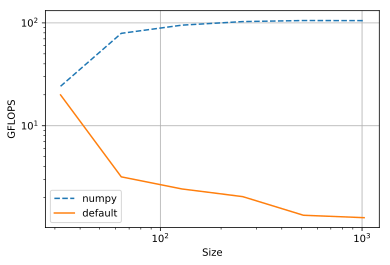

In [11]:
plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'default'])

In [7]:
reorder_gflops = bench_matmul_tvm(reorder, sizes)

time:  4.465226083993912e-06
time:  8.863862603902817e-06
time:  8.713593706488609e-05
time:  0.0008821561932563782
time:  0.010262985248118639
time:  0.0836896481923759


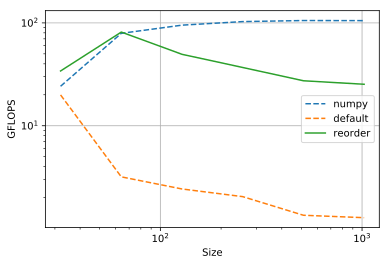

In [10]:
plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops],
            ['numpy', 'default', 'reorder'])